These analyses and simulations use data from Urai et al. 2017, and aim to further pinpoint the relationship between several proxies for confidence on the previous trial.

If you use this work in any way, or see something interesting, please contact me first (anne.urai@gmail.com)! I'm very happy to chat with people about collaborating to better understand these patterns. Thanks.

In [4]:
import numpy as np
import pandas as pd
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="darkgrid", context="talk")
import scipy as sp
from IPython import embed as shell
import psychofit as psy
# import tqdm # progress bar

In [5]:
#### Urai et al. (2018): pupil dilation and reaction times scale with decision uncertainty ####
# try:
#     data_urai2017 = pd.read_csv('https://ndownloader.figshare.com/files/12753785')
#     data_urai2017['choice']        = data_urai2017.resp
#     data_urai2017['evidence']      = data_urai2017.coherence * data_urai2017.stimulus # signed evidence
#     data_urai2017['subj_idx']      = data_urai2017.subjnr

# except:
data_urai2017 = pd.read_csv('/Users/urai/Data/HDDM/NatComm/2ifc_data_hddm.csv')
data_urai2017['choice']        = np.sign(data_urai2017.response - 0.1)
data_urai2017['evidence']      = data_urai2017.stimulus
data_urai2017['sessionnr']     = data_urai2017.session
data_urai2017['blocknr']       = data_urai2017.block
data_urai2017['correct']       = 1 * (np.sign(data_urai2017.stimulus) == data_urai2017.choice)
data_urai2017['decision_pupil'] = data_urai2017.prevpupil.shift(-1)

data_urai2017['coherence'].values[data_urai2017['coherence'] <= 0.025] =  0.025
data_urai2017['coherence'] = data_urai2017['coherence'] * 100
data_urai2017['evidence'] = data_urai2017['coherence'] * np.sign(data_urai2017.stimulus)

In [6]:
# normalize RT for each participant
zscore = lambda x: (x - x.mean()) / x.std()
data_urai2017['rt_norm'] = data_urai2017.groupby(['subj_idx', 'sessionnr', 'blocknr'])['rt'].transform(zscore)
data_urai2017['evidence_norm'] = data_urai2017.groupby(['subj_idx', 'sessionnr', 'blocknr'])['evidence'].transform(zscore)
data_urai2017['coherence_norm'] = data_urai2017.groupby(['subj_idx', 'sessionnr', 'blocknr'])['coherence'].transform(zscore)
data_urai2017['decision_pupil'] = data_urai2017.groupby(['subj_idx', 'sessionnr', 'blocknr'])['decision_pupil'].transform(zscore)

data_urai2017.sample(n=10)

,subj_idx,session,block,trial,stimulus,coherence,response,rt,prevstim,prevresp,...,prev3pupil,choice,evidence,sessionnr,blocknr,correct,decision_pupil,rt_norm,evidence_norm,coherence_norm
41999,18,4,3,45,0.1000,10.0,1,1.02,-1,-1,...,2.039595,1.0,10.0,4,3,1,-0.990630,-0.115254,0.744908,-0.347168
50495,22,2,1,27,-0.3000,30.0,0,0.74,-1,-1,...,0.426876,-1.0,-30.0,2,1,1,-0.334638,0.099458,-1.730324,1.639987
60853,26,3,7,41,-0.3000,30.0,0,0.32,1,1,...,-0.267755,-1.0,-30.0,3,7,1,0.714768,-1.917801,-1.742329,1.560530
17814,8,3,3,43,-0.0125,2.5,0,0.68,1,1,...,-1.962683,-1.0,-2.5,3,3,1,-0.690422,0.042006,-0.436038,-0.596708
10021,5,1,10,28,-0.2000,20.0,0,0.43,-1,-1,...,1.342577,-1.0,-20.0,1,10,1,-1.685843,-0.567258,-1.183189,0.546158
47465,20,5,8,4,0.2000,20.0,1,0.42,1,-1,...,0.990406,1.0,20.0,5,8,1,-1.911564,-0.926856,1.182197,0.662312
53111,23,2,6,10,-0.0500,5.0,0,0.50,1,1,...,1.126950,-1.0,-5.0,2,6,1,0.362542,-0.945887,-0.209642,-0.830185
10727,5,3,5,23,0.2000,20.0,1,0.55,-1,-1,...,0.395690,1.0,20.0,3,5,1,0.184489,-0.073610,1.258366,0.654115
13891,6,5,1,26,-0.0125,2.5,1,0.51,-1,-1,...,2.611660,1.0,-2.5,5,1,0,0.778141,-0.770857,-0.340018,-0.587400
33763,15,1,7,35,0.0500,5.0,1,0.65,-1,-1,...,1.876514,1.0,5.0,1,7,1,0.921922,-0.279468,0.266300,-0.801688


/anaconda3/envs/python3.7/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


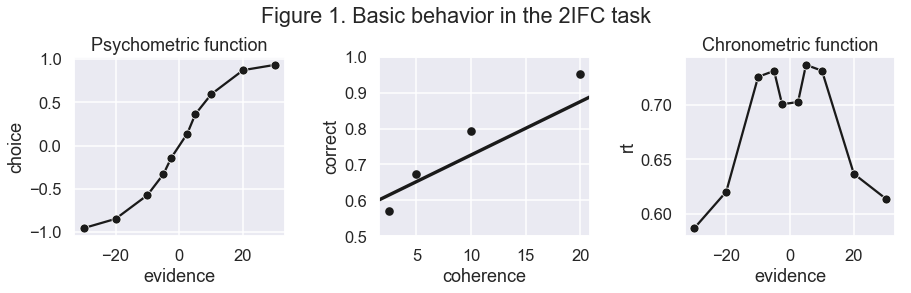

In [7]:
## FIRST, MAKE A QUICK OVERVIEW OF BASIC BEHAVIORAL DATA
fig, ax = plt.subplots(1, 3, figsize=(13,4))
sns.lineplot(data=data_urai2017, x='evidence', y='choice', color='k', marker='o', ci=None,  ax=ax[0])
ax[0].set(title='Psychometric function')
sns.regplot(data=data_urai2017, x='coherence', y='correct', x_bins=5, color='k', marker='o', ci=None, ax=ax[1])
ax[1].set(ylim=[0.5, 1])
sns.lineplot(data=data_urai2017, x='evidence', y='rt', color='k', marker='o', ci=None,ax=ax[2])
ax[2].set(title='Chronometric function')
fig.suptitle('Figure 1. Basic behavior in the 2IFC task', verticalalignment='baseline')
plt.tight_layout()

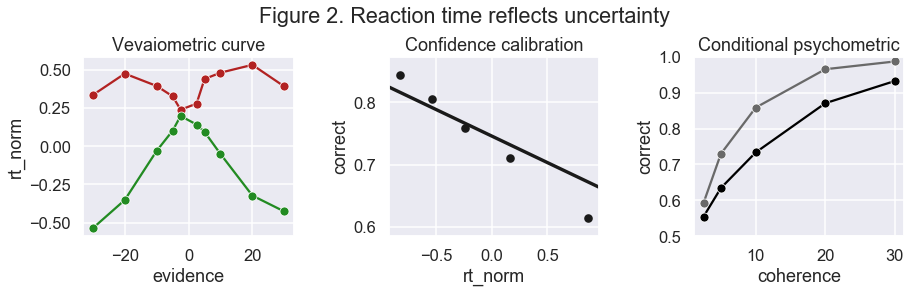

In [8]:
## RT reflects uncertainty
data_urai2017.loc[:,'rt_bin'] = pd.qcut(data_urai2017['rt_norm'], 2, labels=False) # median split

fig, ax = plt.subplots(1, 3, figsize=(13,4))
sns.lineplot(data=data_urai2017, x='evidence', y='rt_norm', hue='correct', marker='o', ax=ax[0], ci=None, palette={0:"firebrick", 1:"forestgreen"}, legend=False)
ax[0].set(title='Vevaiometric curve')
sns.regplot(data=data_urai2017, x='rt_norm', y='correct', x_bins=5, color='k', marker='o', ax=ax[1], ci=None)
ax[1].set(title='Confidence calibration')
sns.lineplot(data=data_urai2017, x='coherence', y='correct', hue='rt_bin', marker='o',ci=None, ax=ax[2], palette={0:"dimgrey", 1:"black"}, legend=False)
ax[2].set(title='Conditional psychometric', ylim=[0.5, 1])
fig.suptitle('Figure 2. Reaction time reflects uncertainty', verticalalignment='baseline')
plt.tight_layout()
# fig.savefig('rt.pdf')

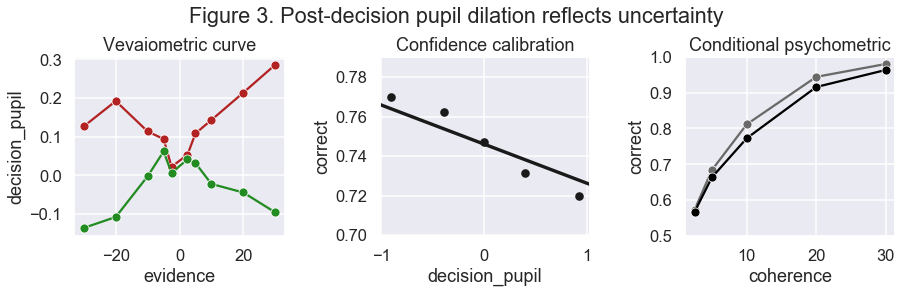

In [9]:
## Pupil reflects uncertainty
data_urai2017.loc[:,'pupil_bin'] = pd.qcut(data_urai2017['decision_pupil'], 2, labels=False) # median split

fig, ax = plt.subplots(1, 3, figsize=(13,4))
sns.lineplot(data=data_urai2017, x='evidence', y='decision_pupil', hue='correct', marker='o', ci=None, ax=ax[0], palette={0:"firebrick", 1:"forestgreen"}, legend=False)
ax[0].set(title='Vevaiometric curve')
sns.regplot(data=data_urai2017, x='decision_pupil', y='correct', x_bins=5, color='k', marker='o', ax=ax[1], ci=None)
ax[1].set(title='Confidence calibration')
sns.lineplot(data=data_urai2017, x='coherence', y='correct', hue='pupil_bin', marker='o', ci=None, ax=ax[2], palette={0:"dimgrey", 1:"black"}, legend=False)
ax[2].set(title='Conditional psychometric', ylim=[0.5, 1])
fig.suptitle('Figure 3. Post-decision pupil dilation reflects uncertainty', verticalalignment='baseline')
plt.tight_layout()
#fig.savefig('pupil.pdf')

In [10]:
# RATHER THAN FITTING PSYCHOMETRIC FUNCTION SHIFTS, DO A QUICK HEURISTIC: REPETITION PROBABILITY
data_urai2017['repeat']              = 1 * (data_urai2017['choice'] == data_urai2017.choice.shift(1))
data_urai2017['previous_coherence']  = data_urai2017.coherence.shift(1)
data_urai2017['previous_choice']     = data_urai2017.choice.shift(1)
data_urai2017['previous_correct']    = data_urai2017.correct.shift(1)
data_urai2017['previous_rt_bins']    = pd.qcut(data_urai2017.rt_norm.shift(1), 3, labels=False) 
data_urai2017['previous_rt']         = data_urai2017.rt_norm.shift(1) 
data_urai2017['previous_pupil_bins'] = pd.qcut(data_urai2017.decision_pupil.shift(1), 3, labels=False) 
data_urai2017['previous_pupil']      = data_urai2017.decision_pupil.shift(1) 

# data_urai2017.loc[:,'current_evidence'] = pd.qcut(data_urai2017['coherence'], 2, labels=False) # median split

In [56]:
## DEFINE UPDATING BASED ON THE PSYCHOMETRIC FUNCTION SHIFT
# from ibl_pipeline.analyses import behavior as behavioral_analyses

def fit_psychfunc(df):
    
    choicedat = df.dropna(subset=['choice']) # ignore missed trials
    choicedat = choicedat.groupby('evidence').agg({'rt':'count', 'response':'mean'}).reset_index()  
    assert(all(choicedat['response'] >= 0)) # make sure we're not using signed choices
    
    if sum(choicedat.rt) > 20: # only fit if each datapoint has at least 10 trials
        pars, L = psy.mle_fit_psycho(choicedat.values.transpose(), P_model='erf_psycho', 
            parstart=np.array([choicedat['evidence'].mean(), 20., 0.05]), 
            parmin=np.array([choicedat['evidence'].min(), 0., 0.]), 
            parmax=np.array([choicedat['evidence'].max(), 100., 1.]))
        df2 = {'bias':pars[0],'threshold':pars[1], 'lapse':pars[2]}
    else:
        df2 = {'bias':np.nan, 'threshold':np.nan, 'lapse':np.nan}
    return pd.DataFrame(df2, index=[0])

def updating(df, colname):
    
    # fit psychometric functions
    psychfuncfits = df.groupby(['subj_idx', 'previous_choice', 'previous_correct', colname]).apply(fit_psychfunc).reset_index()    
    
    # make a new dataframe to compute the bias shift per group
    df2 = pd.DataFrame()
    for name, grouped in psychfuncfits.groupby(['previous_correct', 'subj_idx', colname]):
        if grouped.shape[0] == 2: # skip if there aren't 2 previous responses in this bin
            biasshift = grouped.loc[grouped.previous_choice == -1, 'bias'].item() - grouped.loc[grouped.previous_choice == 1, 'bias'].item()
            df3 = grouped.groupby(['previous_correct', 'subj_idx', colname]).mean().reset_index() # average the rest
            df3['update'] = biasshift # now insert the computed biasshift
            df2 = df2.append(df3)
            
    print(colname)
    df2 = df2.dropna(subset=['update'])
    # print(df2.columns)
    return df2


In [36]:
## NOW FIT THE PSYCHOMETRIC FUNCTION SHIFT, DEPENDING ON PREVIOUS COHERENCE
coherence_update = updating(data_urai2017, 'previous_coherence')
pupil_update     = updating(data_urai2017, 'previous_pupil_bins')
rt_update        = updating(data_urai2017, 'previous_rt_bins')

previous_coherence
previous_pupil_bins
previous_rt_bins


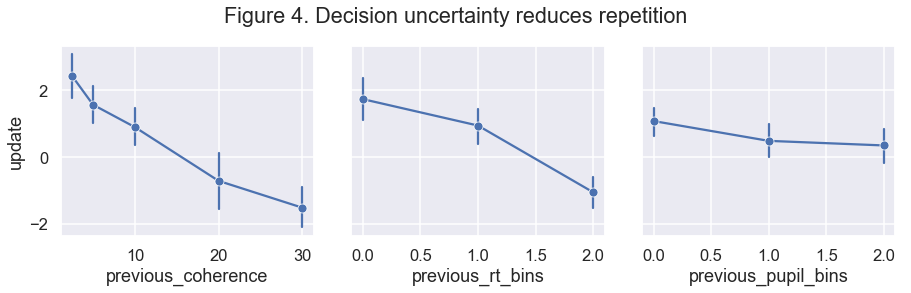

In [37]:
## HOW DO PUPIL, RT AND COHERENCE AFFECT NEXT-TRIAL UPDATING?
fig, ax = plt.subplots(1, 3, figsize=(13,4), sharey=True)
kwargs = {'y':'update', 'ci':68, 'marker':'o', 'estimator':np.nanmean, 'err_style':"bars"}
sns.lineplot(data=coherence_update[coherence_update.previous_correct == 1], x='previous_coherence',  ax=ax[0], **kwargs)
sns.lineplot(data=rt_update[rt_update.previous_correct == 1], x='previous_rt_bins', ax=ax[1], **kwargs)
sns.lineplot(data=pupil_update[pupil_update.previous_correct == 1], x='previous_pupil_bins', ax=ax[2], **kwargs)
fig.suptitle('Figure 4. Decision uncertainty reduces repetition', verticalalignment='baseline')
plt.tight_layout()
fig.savefig('updating.pdf')

In [70]:
## DO THE RT-BINNING PER LEVEL OF PREVIOUS COHERENCE
def updating_2split(df, colname1, colname2):
    
    # fit psychometric functions
    psychfuncfits = df.groupby(['subj_idx', 'previous_choice', 'previous_correct', colname1, colname2]).apply(fit_psychfunc).reset_index()    
    
    # make a new dataframe to compute the bias shift per group
    df2 = pd.DataFrame()
    for name, grouped in psychfuncfits.groupby(['previous_correct', 'subj_idx', colname1, colname2]):
        if grouped.shape[0] == 2: # skip if there aren't 2 previous responses in this bin
            biasshift = grouped.loc[grouped.previous_choice == -1, 'bias'].item() - grouped.loc[grouped.previous_choice == 1, 'bias'].item()
            df3 = grouped.groupby(['previous_correct', 'subj_idx', colname1, colname2]).mean().reset_index() # average the rest
            df3['update'] = biasshift # now insert the computed biasshift
            df2 = df2.append(df3)
            
    df2 = df2.dropna(subset=['update'])
    print(colname1)
    print(colname2)
    # print(df2.columns)
    return df2

In [71]:
# NOW DO THE SPLIT INTO PUPIL OR RT BINS, BUT PER LEVEL OF PREVIOUS COHERENCE
def shiftrt_percoh(x):
    return pd.qcut(x, 4, labels=False)
    
data_urai2017['previous_rt_bins_percoh'] = data_urai2017.groupby(['previous_coherence'])['previous_rt'].apply(shiftrt_percoh)
rt_update_percoh = updating_2split(data_urai2017, 'previous_rt_bins_percoh', 'previous_coherence')

data_urai2017['previous_pupil_bins_percoh'] = data_urai2017.groupby(['previous_coherence'])['previous_pupil'].apply(shiftrt_percoh)
pupil_update_percoh = updating_2split(data_urai2017, 'previous_pupil_bins_percoh', 'previous_coherence')
rt_update_percoh.head(n=10)

previous_rt_bins_percoh
previous_coherence
previous_pupil_bins_percoh
previous_coherence


,previous_correct,subj_idx,previous_rt_bins_percoh,previous_coherence,previous_choice,level_5,bias,lapse,threshold,update
0,0.0,1,0.0,2.5,0.0,0,-1.540719,9.112686e-11,30.034013,-2.513598
0,0.0,1,1.0,2.5,0.0,0,2.321820,5.169082e-02,21.555405,-3.891155
0,0.0,1,2.0,2.5,0.0,0,0.264076,2.606105e-11,18.263647,-6.227803
0,0.0,1,2.0,5.0,0.0,0,1.810546,5.477974e-12,36.786290,4.943931
0,0.0,1,3.0,2.5,0.0,0,1.709106,1.811594e-01,6.523152,-12.502599
0,0.0,1,3.0,5.0,0.0,0,-1.004352,1.529344e-11,27.731667,-5.282243
0,0.0,2,0.0,2.5,0.0,0,0.347577,1.387654e-11,11.537617,2.469326
0,0.0,2,1.0,2.5,0.0,0,-0.774735,7.086719e-11,11.706885,-3.226901
0,0.0,2,2.0,2.5,0.0,0,-2.600332,4.361485e-11,27.633340,13.060322
0,0.0,2,3.0,2.5,0.0,0,0.902776,3.178982e-11,10.616158,0.598255


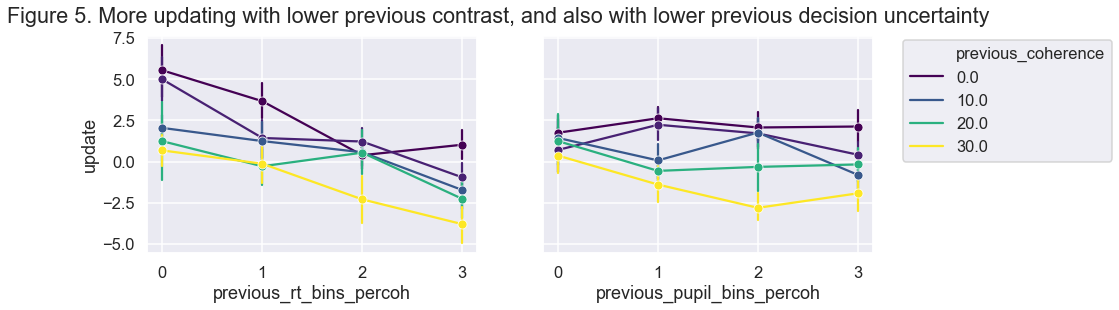

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(13,4), sharey=True)
sns.lineplot(data=rt_update_percoh[rt_update_percoh.previous_correct == 1], x='previous_rt_bins_percoh', 
             hue='previous_coherence', legend=False, ax=ax[0], palette='viridis', **kwargs)
sns.lineplot(data=pupil_update_percoh[pupil_update_percoh.previous_correct == 1], x='previous_pupil_bins_percoh', 
             hue='previous_coherence', legend='brief', palette='viridis',  ax=ax[1], **kwargs)
lgd = ax[1].legend(loc='center right', bbox_to_anchor=(1.75, 0.7), ncol=1) # move box outside
fig.suptitle('Figure 5. More updating with lower previous contrast, and also with lower previous decision uncertainty')
fig.savefig('updating_percoh.pdf')

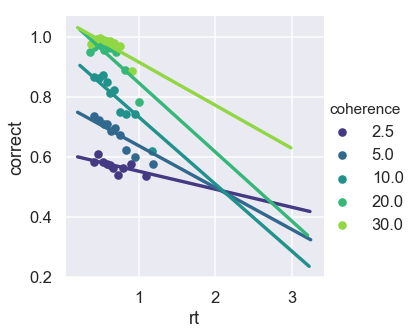

In [87]:
sns.lmplot(data=data_urai2017, x='rt', y='correct', hue='coherence', 
           x_bins=10, palette='viridis', truncate=True, ci=None)

* Stronger coherence -> more correct / more confidence
* Within each coherence level, fast RT -> more correct / more confidence

*BUT*

* Stronger coherence -> less updating on next trial
* Within each coherence level, fast RT -> more updating on next trial

In [75]:
## test anova
from statsmodels.formula.api import ols
formula = 'update ~ previous_coherence*previous_rt_bins_percoh'
lm = ols(formula, rt_update_percoh).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 update   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     19.46
Date:                Thu, 06 Jun 2019   Prob (F-statistic):           5.74e-12
Time:                        15:01:14   Log-Likelihood:                -1643.3
No. Observations:                 520   AIC:                             3295.
Df Residuals:                     516   BIC:                             3312.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [76]:

## test anova
formula = 'update ~ previous_coherence*previous_pupil_bins_percoh'
lm = ols(formula, pupil_update_percoh).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 update   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     8.103
Date:                Thu, 06 Jun 2019   Prob (F-statistic):           2.73e-05
Time:                        15:01:24   Log-Likelihood:                -1731.7
No. Observations:                 561   AIC:                             3471.
Df Residuals:                     557   BIC:                             3489.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

**Conclusion**: the weaker the previous coherence, the larger the choice update (i.e. more information about the bound placement). However, _within_ each level of coherence, faster RTs (so a more confident choice) also lead to stronger updating. 
Even when ignoring previous coherence, and just grouping by RT, this captures the 


In [60]:
### CAN ALSO USE STATSMODELS!
import statsmodels.api as sm
import statsmodels.formula.api as smf

data_urai2017 = data_urai2017.dropna(subset=['previous_coherence', 'previous_rt', 'previous_pupil'])
designM = data_urai2017[['evidence', 'previous_coherence', 'previous_choice']]
designM['prev_coh_resp'] = designM.previous_choice * designM.previous_coherence
designM = sm.add_constant(designM, prepend=True)

logit_mod = sm.Logit(data_urai2017.response, designM)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

# md = smf.mixedlm("response ~ evidence", data_urai2017, groups=data_urai2017["subj_idx"], family=sm.families.Binomial())
# mdf = data_urai2017.fit()
# print(mdf.summary())

                           Logit Regression Results                           
Dep. Variable:               response   No. Observations:                64343
Model:                          Logit   Df Residuals:                    64338
Method:                           MLE   Df Model:                            4
Date:                Sun, 02 Jun 2019   Pseudo R-squ.:                  0.2936
Time:                        16:32:03   Log-Likelihood:                -31501.
converged:                       True   LL-Null:                       -44595.
                                        LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0030      0.014     -0.209      0.834      -0.031       0.025
evidence               0.1281      0.001    109.410      0.000       0.126       0.130
previous_coherence  

/anaconda3/envs/python3.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [61]:
### CAN ALSO USE STATSMODELS!
import statsmodels.api as sm
import statsmodels.formula.api as smf

designM = data_urai2017[['evidence', 'previous_rt', 'previous_choice']]
designM['prev_rt_resp'] = designM.previous_choice * designM.previous_rt
designM = sm.add_constant(designM, prepend=True)

logit_mod = sm.Logit(data_urai2017.response, designM)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:               response   No. Observations:                64343
Model:                          Logit   Df Residuals:                    64338
Method:                           MLE   Df Model:                            4
Date:                Sun, 02 Jun 2019   Pseudo R-squ.:                  0.2931
Time:                        16:32:04   Log-Likelihood:                -31525.
converged:                       True   LL-Null:                       -44595.
                                        LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0152      0.010      1.566      0.117      -0.004       0.034
evidence            0.1281      0.001    109.454      0.000       0.126       0.130
previous_rt         0.0148      

/anaconda3/envs/python3.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
### CAN ALSO USE STATSMODELS!
import statsmodels.api as sm
import statsmodels.formula.api as smf

designM = data_urai2017[['evidence', 'previous_pupil', 'previous_choice']]
designM['prev_pupil_resp'] = designM.previous_choice * designM.previous_pupil
designM = sm.add_constant(designM, prepend=True)

logit_mod = sm.Logit(data_urai2017.response, designM)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:               response   No. Observations:                64343
Model:                          Logit   Df Residuals:                    64338
Method:                           MLE   Df Model:                            4
Date:                Sun, 02 Jun 2019   Pseudo R-squ.:                  0.2927
Time:                        16:32:31   Log-Likelihood:                -31542.
converged:                       True   LL-Null:                       -44595.
                                        LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0159      0.010      1.642      0.101      -0.003       0.035
evidence            0.1280      0.001    109.424      0.000       0.126       0.130
previous_pupil      0.0079      

/anaconda3/envs/python3.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [64]:
## NOW COMBINE ALL 3 IN ONE MODEL..

designM = data_urai2017[['evidence', 'previous_coherence', 'previous_rt', 'previous_pupil', 'previous_choice']]
designM['prev_coh_resp'] = designM.previous_choice * designM.previous_coherence
designM['prev_rt_resp'] = designM.previous_choice * designM.previous_rt
designM['prev_pupil_resp'] = designM.previous_choice * designM.previous_pupil
designM = sm.add_constant(designM, prepend=True)

logit_mod = sm.Logit(data_urai2017.response, designM)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:               response   No. Observations:                64343
Model:                          Logit   Df Residuals:                    64334
Method:                           MLE   Df Model:                            8
Date:                Sun, 02 Jun 2019   Pseudo R-squ.:                  0.2950
Time:                        16:34:59   Log-Likelihood:                -31440.
converged:                       True   LL-Null:                       -44595.
                                        LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0144      0.015     -0.980      0.327      -0.043       0.014
evidence               0.1283      0.001    109.443      0.000       0.126       0.131
previous_coherence  

/anaconda3/envs/python3.7/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/envs/python3.7/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/envs/python3.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc